# Adult Income - Feature Engineering & Selection
---
__Date Created:__ 2020-06-26  
__Author:__ Josh Mischung  
__email:__ josh@knoasis.io  

__Dataset:__ [Adult Income, UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Adult)

__Comments on Dataset & Objectives:__  
The objective of this notebook is the reduction of required to generate a probability for the event of interest. The reduction of features must maintain, or improve upon, prior model performance. For this project the motivation for reducing the required number of features is to make the model easier to interact with for end-users by reducing the quantity of information they're required to input to produce a probability score. 

<br>

# Imports & Functions
---

__Imports__

In [1]:
"""
Supress FutureWarnings generated by imblearn using
sklearn method locations that will be deprecated
"""
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# From the usual suspects
from collections import Counter
from numpy import unique
from numpy import mean
from numpy import std
from pandas import read_pickle
from pandas import DataFrame
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from category_encoders.woe import WOEEncoder
from imblearn.over_sampling import SMOTENC

# Pipeline
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Feature engineering & selection
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Evaluation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score

# Config
from sklearn import set_config
set_config(display='diagram')

Using TensorFlow backend.


__Functions__

In [21]:
# Evaluate models
def evaluate_model(X, y, model):
    """
    *Reference sklearn.metrics.SCORERS.keys() for list of available scorers*
    """
    # Define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=143)
    # Evaluate model
    scores = cross_validate(model, X, y, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], cv=cv, n_jobs=-1)
    return scores


def roc_auc_est(unfitted_model, X, y):
    y_pred = unfitted_model.fit(X, y).predict_proba(X)
    return roc_auc_score(y, y_pred[:, 1]).round(4)


# Split & smote resample data
def split_resample(feature_df, target):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(feature_df, target, test_size=0.1, stratify=y, random_state=142)

    # Obtain catigorical column indicies
    cat_feats = feature_df.select_dtypes('category').columns.tolist()
    cat_index = [feature_df.columns.get_loc(col) for col in cat_feats]
    
    # Resample with smote
    smt = SMOTENC(random_state=143, categorical_features=cat_index)
    X_train, y_train = smt.fit_sample(X_train, y_train)
    
    # Revert to pandas objects
    X_train = DataFrame(X_train, columns=feature_df.columns)
    y_train = Series(y_train, name=target.name)
    
    # Revert to original dtype
    X_train[X_train.loc[:, cat_feats].columns] = X_train.loc[:, cat_feats].apply(lambda x: x.astype('category'))
    X_train[X_train.select_dtypes(['object']).columns] = X_train.select_dtypes(['object'])\
                                                                .apply(lambda x: x.astype('int64'))
    
    # Print target category counts
    title = "Resampled Target Category Counts"
    counts = unique(y_train, return_counts=True)
    print(f"{title}\n{'-' * len(title)}")
    print(f"{counts[0][0]}: {counts[1][0]}\n{counts[0][1]}: {counts[1][1]}")
    
    return X_train, X_test, y_train, y_test


# Models dictionary
def get_models():
    models_dict = {
        'LogReg': LogisticRegression(fit_intercept=True, max_iter=10000, n_jobs=-1),
        'SGD': SGDClassifier(max_iter=10000, tol=1e-3, n_jobs=-1),
        'Perceptron': Perceptron(max_iter=10000, tol=1e-3, n_jobs=-1),
        'PassiveAgressive': PassiveAggressiveClassifier(max_iter=10000, tol=1e-3, n_jobs=-1),
        'CART': DecisionTreeClassifier(),
        'BAG': BaggingClassifier(n_estimators=100, n_jobs=-1),
        'RF': RandomForestClassifier(n_estimators=100, n_jobs=-1),
        'GBM': GradientBoostingClassifier(n_estimators=100)
    }
    
    return models_dict


<br>  
# Load & Process Data
---

In [23]:
# Load data
data = 'adult_df_postEDA.pkl'
adult_df = read_pickle(data)

# Split data
X = adult_df.iloc[:, :-1]
y = adult_df.iloc[:, -1]
X_train, X_test, y_train, y_test = split_resample(X, y)

# Convert categories to numeric
woe = WOEEncoder(regularization=1e-8, random_state=143)
X_train[X_train.select_dtypes('category').columns] = woe.fit_transform(X_train.select_dtypes('category'), y_train)

# Scale data
cols = X.columns.tolist()
X_train = RobustScaler().fit_transform(X_train)
X_train = DataFrame(X_train, columns=cols)

Resampled Target Category Counts
--------------------------------
0: 22247
1: 22247


<br>  
# Feature Engineering
---

__Interactions__  
Scikit-Learn's Gradient Boosting Classifier was the highest performing classification algorithm in Notebook2, so it was chosen as the base model for evaluating engineered features.

In [24]:
# Build pipeline
clf = Pipeline(steps=[
    ('classifier', GradientBoostingClassifier(n_estimators=100))
])

# Model baseline
baseline = roc_auc_est(clf, X_train, y_train)
print(f"Baseline ROC-AUC: {baseline}")

Baseline ROC-AUC: 0.9661


In [7]:
# Create separate df to include interactions
Xi_train = X_train.copy()

# Features object
feats = X.columns

# Create interactions
interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
Xi = interactions.fit_transform(X_train)
main_effects = interactions.n_input_features_

# Partial ROC-AUC for interactions above 0.001
for k, effect in enumerate(interactions.powers_[(main_effects):]):
    term_A, term_B = [i for i, j in zip(feats, effect==1) if j]
    increment = roc_auc_est(clf, Xi[:, list(range(0, main_effects)) +\
                            [main_effects + k]], y_train) - baseline
    if increment >= 0.001:
        col = f"{term_A} * {term_B}"
        Xi_train[col] = X_train[term_A] * X_train[term_B]
        print('Adding interaction %s * %s ROC-AUC: %5.3f' % (term_A, term_B, increment))

Adding interaction education * education_num ROC-AUC: 0.001
Adding interaction education_num * native_country ROC-AUC: 0.001


<br>  
# Feature Selection
---

### Univariate Filter Method - Mutual Information

In [8]:
# Custom mutual_info_classif function with discrete_features hard-coded
def mutual_info_classif_custom(X, y):
    # To change discrete_features,
    # you need to redefine the function each time
    # because once the func def is supplied to selectKBest, it cannot be changed
    discrete_features = [1, 3, 5, 6, 7, 8, 9, 13]
    
    return mutual_info_classif(X, y, discrete_features)

In [9]:
# For storing feat-pairing scores
filter_scores_dict = {}

for K in range(1, Xi_train.shape[1] + 1):
    # Select features
    filtered = SelectKBest(mutual_info_classif_custom, k=K).fit(Xi_train, y_train)
    feats = Xi_train.loc[:, filtered.get_support()].columns.tolist()
    
    # Test model with selected features
    scores = evaluate_model(Xi_train.loc[:, feats], y_train, clf)
    
    # Add features and score to dict
    filter_scores_dict[K] = feats, mean(scores['test_roc_auc']).round(4)

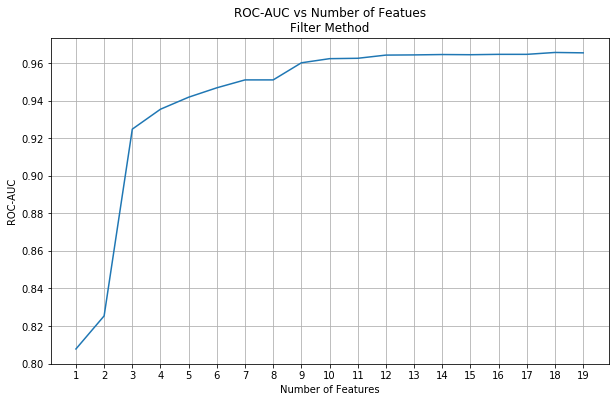

In [19]:
# Isolate scores
x = []
y = []
for k, v in filter_scores_dict.items():
    x.append(k)
    y.append(v[1])

# Plot roc-auc change
fig = plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title("ROC-AUC vs Number of Featues\nFilter Method")
plt.xlabel("Number of Features")
plt.xticks(range(1, 20))
plt.ylabel("ROC-AUC")
plt.grid()
plt.show();

### Wrapper Methods - Forward and Backward Selections

__Forward Selection__

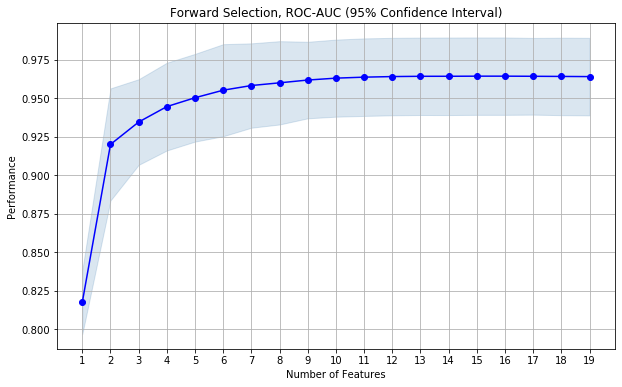

In [13]:
# Instantiate and fit mlxtend's Sequential Feature Selector
sfs = SFS(clf, k_features=19, forward=True, floating=False, scoring='roc_auc', cv=10, n_jobs=-1).fit(Xi_train, y_train)

# Plot 
fig = plot_sfs(sfs.get_metric_dict(), kind='ci', figsize=(10,6))
plt.title("Forward Selection, ROC-AUC (95% Confidence Interval)")
plt.grid()
plt.show();

__Recursive Feature Elimination__

In [15]:
# GBM instance
gbm = GradientBoostingClassifier(n_estimators=100)

# For storing feat-pairing scores
rfe_scores_dict = {}

for K in range(1, Xi_train.shape[1] + 1):
    # Select features
    rfe = RFE(gbm, n_features_to_select=K, step=1).fit(Xi_train, y_train)
    feats = Xi_train.loc[:, rfe.get_support()].columns.tolist()
    
    # Test model with selected features
    scores = evaluate_model(Xi_train.loc[:, feats], y_train, clf)
    
    # Add features and score to dict
    rfe_scores_dict[K] = feats, mean(scores['test_roc_auc']).round(4)

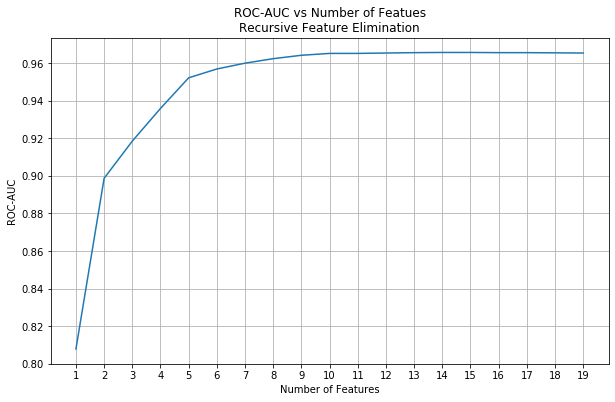

In [16]:
# Isolate scores
x = []
y = []
for k, v in rfe_scores_dict.items():
    x.append(k)
    y.append(v[1])

# Plot roc-auc change
fig = plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title("ROC-AUC vs Number of Featues\nRecursive Feature Elimination")
plt.xlabel("Number of Features")
plt.xticks(range(1, 20))
plt.ylabel("ROC-AUC")
plt.grid()
plt.show();

# Summary
---  
<br>
To restate, the baseline model ROC-AUC score with the original 17 features and before feature engineering or selection was 0.9661. After searching for interactions between features and applying several feature selection methods (filter, forward selection, recursive feature elimination) the baseline performance remains the best, but several combinations came as close as 0.0004 to the baseline, or realized the majority of model performance with as few as 4 features.  

Recursive Feature Elimination reached a peak ROC-AUC of 0.9657 with 14 features.  Forward selection was able to produce scores of 0.9504 and 0.9601 with 4 and 7 features, respectively.  

The objective of this effort is top performance, so the original features will be used. However, the use-case in live applications of a model should factor into the decision about how many features to use. If, for instance, each feature needed to be acquired and entered by a customer it might be advantageous to consider 4 or 7 features since it will improve the user-experience and reduce the opportunity for user-error. If computations are a bottleneck the sacrifice of 0.0004 may prove to be worthwhile.  

One last note, when engineering and selecting features overfitting is often a concern, so testing against a holdout dataset is an important step to confirm that the performance of the model generalizes.